In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib as plt
import time
import PIL
import os
import skimage as ski
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt


In [2]:
def calculate_GLI(image):
    # Convert image to float32
    img_float = image.astype(np.float32)

    # Split the image into its RGB channels
    red_channel = img_float[:, :, 0]
    green_channel = img_float[:, :, 1]
    blue_channel = img_float[:, :, 2]

    # Calculate the GLI
    gli = (green_channel - red_channel - (10 * blue_channel)) / (green_channel + red_channel + (10 * blue_channel))

    # Scale GLI to [0, 255]
    gli_scaled = ((gli + 1) / 2) * 255

    return gli_scaled.astype(np.uint8)


def generate_synthetic_NIR(gray_img):
    # Apply contrast stretching to enhance the contrast of the grayscale image
    min_intensity = np.min(gray_img)
    max_intensity = np.max(gray_img)
    stretched_img = cv2.convertScaleAbs(gray_img, alpha=255.0/(max_intensity-min_intensity), beta=-min_intensity*(255.0/(max_intensity-min_intensity)))

    # Apply thresholding to identify regions corresponding to vegetation
    _, vegetation_mask = cv2.threshold(stretched_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Convert the mask to a binary image
    vegetation_binary = cv2.threshold(vegetation_mask, 1, 255, cv2.THRESH_BINARY)[1]

    # Dilate the binary image to enhance vegetation regions
    kernel = np.ones((5, 5), np.uint8)
    dilated_vegetation = cv2.dilate(vegetation_binary, kernel, iterations=1)

    # Create a synthetic NIR band by multiplying the grayscale image with the dilated vegetation mask
    synthetic_NIR = cv2.bitwise_and(gray_img, gray_img, mask=dilated_vegetation)

    return synthetic_NIR

def generate_synthetic_red(rgb_img):
    # Split the RGB image into its channels
    red_channel = rgb_img[:, :, 2]  # Red channel is the third channel (index 2)

    # Apply contrast stretching to enhance the contrast of the red channel
    min_intensity = np.min(red_channel)
    max_intensity = np.max(red_channel)
    stretched_red_channel = cv2.convertScaleAbs(red_channel, alpha=255.0/(max_intensity-min_intensity), beta=-min_intensity*(255.0/(max_intensity-min_intensity)))

    return stretched_red_channel

def erode_dilate(img):
    # Define the kernel size (experiment with different sizes for better results on your image)
    kernel = np.ones((5, 5), np.uint8) 
    
    # Apply erosion to remove small white points at the edges of objects
    eroded_img = cv2.erode(img, kernel, iterations=2)
    
    # Apply dilation to slightly enlarge the desired objects after erosion
    dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)

    return dilated_img

def thresh_value_grey(img):
    # Initialize the smallest non-zero value to a large number
    smallest_non_zero = float('inf')
    
    # Iterate over each pixel in the image
    for row in img:
        for pixel in row:
            # Check if the pixel value is non-zero and smaller than the current smallest non-zero value
            if pixel != 0 and pixel < smallest_non_zero:
                smallest_non_zero = pixel
    return smallest_non_zero

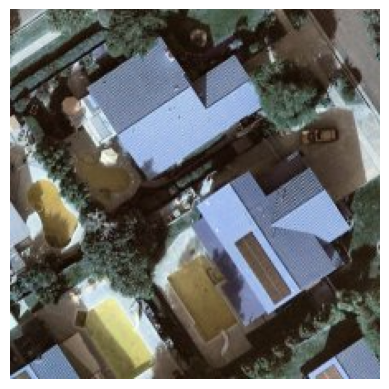

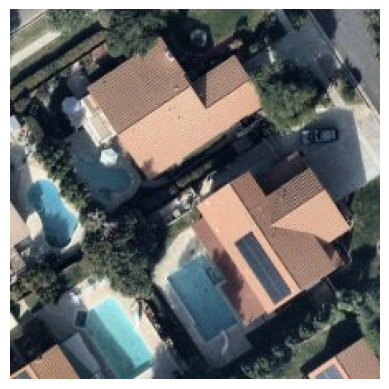

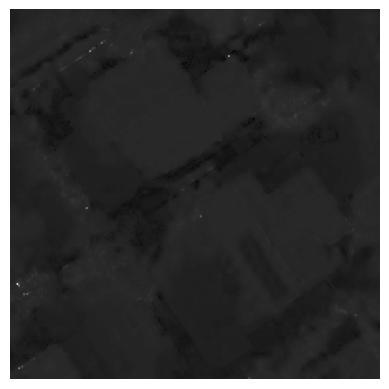

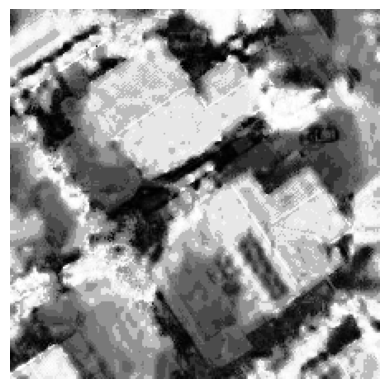

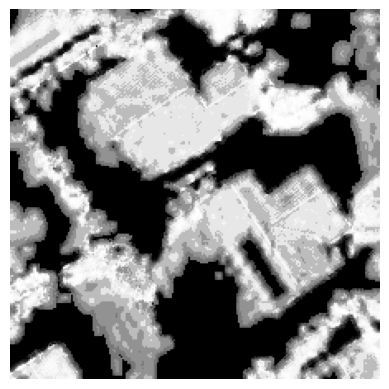

NIR


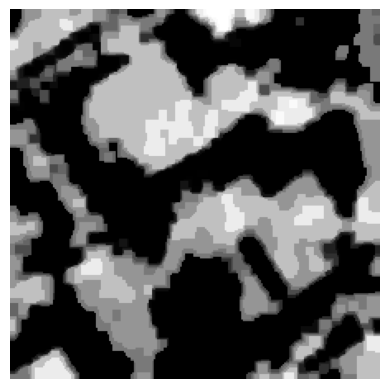

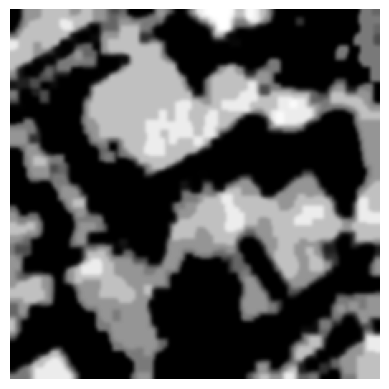

'test_img = -(img_equalized - img_eroded)\nplt.imshow(test_img, cmap="gray")\nplt.axis("off")\nplt.show()\n\n# Apply the threshold\nthresholded_img = cv2.bitwise_and(image, image, mask=test_img)\nplt.imshow(thresholded_img)\nplt.axis("off")\nplt.show()'

In [3]:
# Read the image
image = cv2.imread('DATABASE/training_data/images/000000015.jpg' )
plt.imshow(image)
plt.axis("off")
plt.show()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis("off")
plt.show()

#Calculate GLI(Green-Leaf Index), out put as gray scale
image_GLI = calculate_GLI(image)
plt.imshow(image_GLI, cmap="gray")
plt.axis("off")
plt.show()
# Apply histogram equalization
img_equalized = cv2.equalizeHist(image_GLI)
plt.imshow(img_equalized, cmap="gray")
plt.axis("off")
plt.show()
#Simmulate a NIR(near-infrared) on img
img_NIR = generate_synthetic_NIR(img_equalized)
plt.imshow(img_NIR, cmap="gray")
plt.axis("off")
plt.show()
print("NIR")

img_eroded = erode_dilate(img_NIR)
plt.imshow(img_eroded, cmap="gray")
plt.axis("off")
plt.show()

img_eroded_blur = cv2.GaussianBlur(img_eroded, (5, 5), 0)
plt.imshow(img_eroded_blur, cmap="gray")
plt.axis("off")
plt.show()


"""test_img = -(img_equalized - img_eroded)
plt.imshow(test_img, cmap="gray")
plt.axis("off")
plt.show()

# Apply the threshold
thresholded_img = cv2.bitwise_and(image, image, mask=test_img)
plt.imshow(thresholded_img)
plt.axis("off")
plt.show()"""


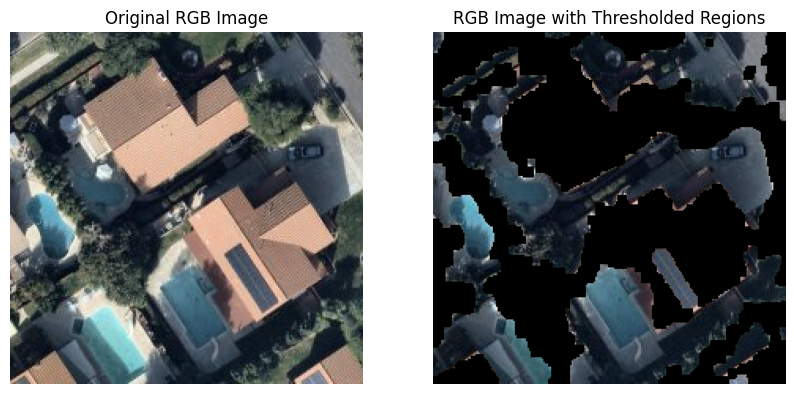

In [4]:
image = cv2.imread('DATABASE/training_data/images/000000015.jpg' )
# Apply thresholding to the RGB image based on the grayscale image
threshold_value = thresh_value_grey(img_eroded_blur) + 20  # Adjust threshold value as needed
_, thresholded_image = cv2.threshold(img_eroded, threshold_value, 255, cv2.THRESH_BINARY)

# Convert the thresholded image to a mask (0 for thresholded regions, 255 for others)
mask = cv2.bitwise_not(thresholded_image)

# Convert the mask to 3-channel for compatibility with the RGB image
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

# Mask the original RGB image with the thresholded result
masked_image = cv2.bitwise_and(image, mask)

# Plot the original RGB image and the masked result
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original RGB Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
plt.title('RGB Image with Thresholded Regions')
plt.axis('off')

plt.show()

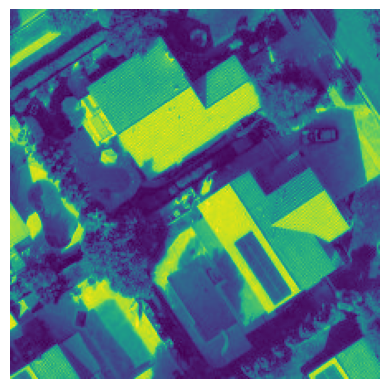

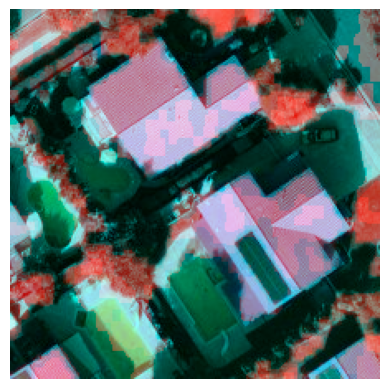

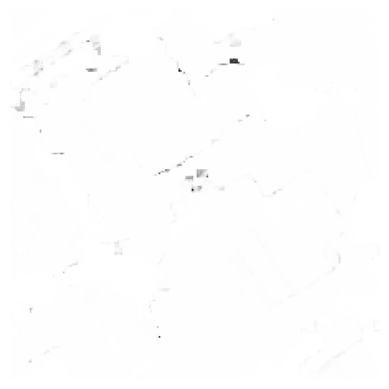

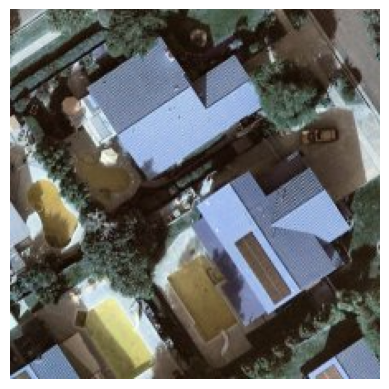

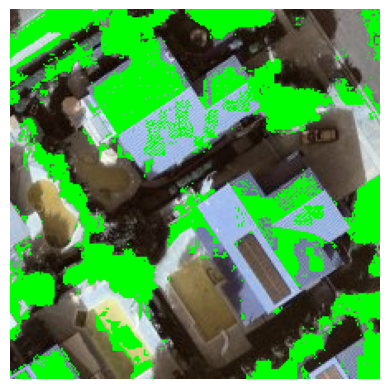

In [5]:
#Might not be useful or not used...


#Synthetic red band
synthetic_red = generate_synthetic_red(image)
plt.imshow(synthetic_red)
plt.axis("off")
plt.show()

# Merge the synthetic NIR, red, and original green channels into a single image
false_color_composite = cv2.merge((img_eroded, image[:,:,1], synthetic_red))
plt.imshow(false_color_composite)
plt.axis("off")
plt.show()
# Convert the data type to float32 for numerical stability in calculations
synthetic_NIR = img_eroded.astype(np.float32)
synthetic_red = synthetic_red.astype(np.float32)

# Calculate the NDVI-like index
#ndvi_like_index = (synthetic_NIR - synthetic_red) / (synthetic_NIR + synthetic_NIR)
# Assuming synthetic_NIR and synthetic_red are NumPy arrays
ndvi_like_index = np.zeros_like(synthetic_NIR, dtype=float)  # Initialize an array to store the result

# Avoid division by zero by checking where synthetic_NIR is not zero
non_zero_indices = synthetic_NIR != 0

# Calculate ndvi_like_index where synthetic_NIR is not zero
ndvi_like_index[non_zero_indices] = (synthetic_NIR[non_zero_indices] - synthetic_red[non_zero_indices]) / \
                                    (synthetic_NIR[non_zero_indices] + synthetic_NIR[non_zero_indices])
    
plt.imshow(ndvi_like_index, cmap="gray")
plt.axis("off")
plt.show()

"""# Scale the index to the range [0, 255] for visualization (optional)
ndvi_like_index_scaled = ((ndvi_like_index + 1) / 2) * 255
plt.imshow(ndvi_like_index_scaled)
plt.axis("off")
plt.show()"""
# Threshold the NDVI-like index to separate water bodies and vegetation
_, water_mask = cv2.threshold(ndvi_like_index, 0, 255, cv2.THRESH_BINARY)
water_mask = cv2.bitwise_not(water_mask)  # Invert the mask to represent water as white

# Apply the water mask to the false-color composite image
image[np.where((water_mask == 255))] = [0, 0, 255]  # Set water bodies to red
plt.imshow(image)
plt.axis("off")
plt.show()

# Invert the water mask to represent vegetation as white
vegetation_mask = cv2.bitwise_not(water_mask)

# Apply the vegetation mask to the false-color composite image
image[np.where((vegetation_mask == 255))] = [0, 255, 0]  # Set vegetation to green
plt.imshow(image)
plt.axis("off")
plt.show()
